# Answering Business Questions using SQL

The chinook SQLite sample database will be used for this project.

It's schema is as illustrated below:
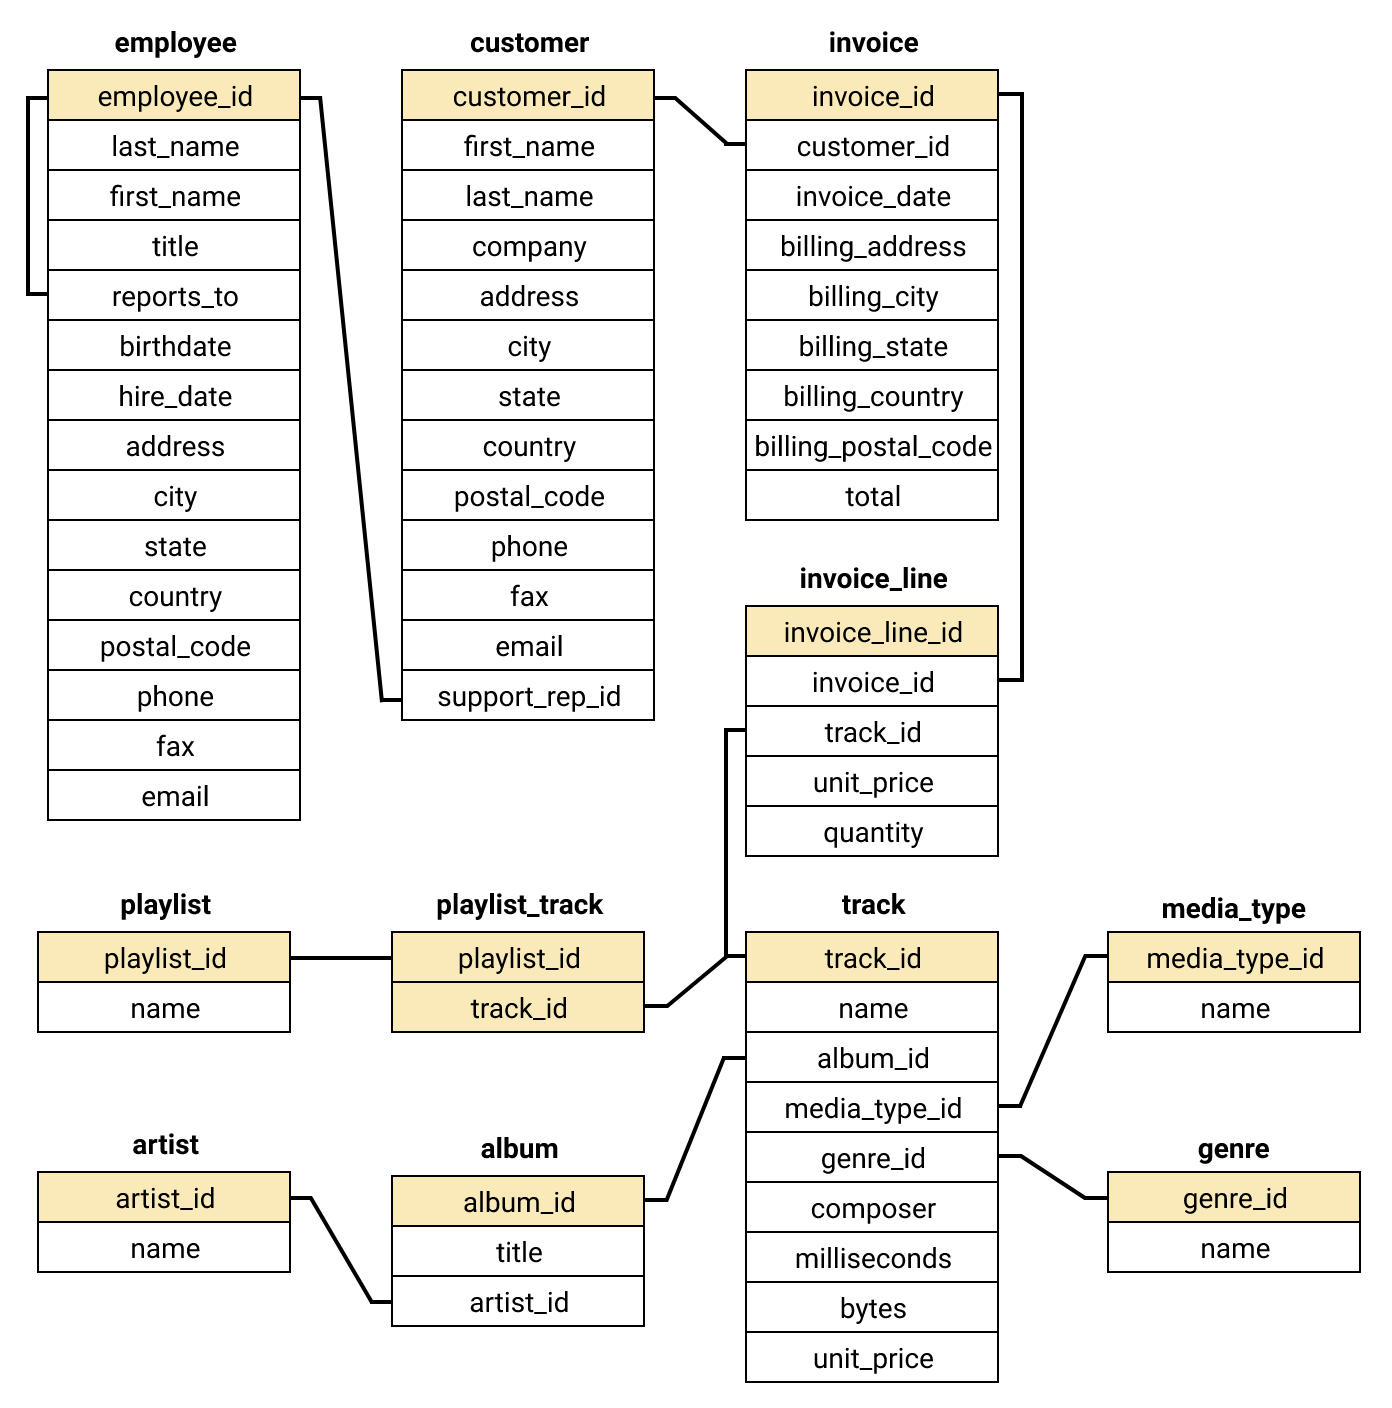

The tables in the database are:
- `employee` table: Stores employees data such as employee id, last name, first name, etc. It also has a field named reports_to to specify who reports to whom.
- `customer` table: Stores customers data.
- `invoice` & `invoice_line` tables: These two tables store invoice data. The invoice table stores invoice header data and the invoice_line table stores the invoice line items data.
- `artist` table: Stores artists data. It is a simple table that contains only the artist id and name.
- `album` table: Stores data about a list of tracks. Each album belongs to one artist. However, one artist may have multiple albums.
- `media_type` table: Stores media types such as MPEG audio and AAC audio files.
- `genre` table: Stores music types such as rock, jazz, metal, etc.
- `track` table: Stores the data of songs. Each track belongs to one album.
- `playlist` & `playlist_track` tables: Playlist table store data about playlists. Each playlist contains a list of tracks. Each track may belong to multiple playlists. The relationship between the playlist table and playlist_track table is many-to-many. The playlist_track table is used to reflect this relationship.

## Import Libraries

The libraries used in the project are:
- `pandas`: It offers data structures and operations for manipulating numerical tables and time series.
- `sqlite3`: It provides an SQL interface to work with SQLite database.
- `src`: It contains all python code written to successfully execute this project.

In [1]:
import sqlite3
import src.functions as fn

## Connect to Database

In [2]:
conn = sqlite3.connect('data/chinook.db')
print('Connection successful')

Connection successful


## Display Tables in the Database

In [3]:
query = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
fn.show_tables(query, conn)

['album',
 'artist',
 'customer',
 'employee',
 'genre',
 'invoice',
 'invoice_line',
 'media_type',
 'playlist',
 'playlist_track',
 'track']

## Case 1: Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you're in charge of choosing the first three albums to be added to the store. There are four albums to choose from, and all four are by artists who don't have any tracks in the store right now. Below is the list of artist names and the genre of music they produce:

|Artist Name |	Genre |
| --- | --- |
| Regal	| Hip-Hop |
| Red Tone	| Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA. To aid in selecting albums, we're interested in finding out which genres sell the best in the USA.

### Commentary

In order to find the genres that sell best in the USA, we need to link genres to billing_country in the invoice table. We will then count the sales occurence of each genre in the USA. The output will be ranked in a descending order and the top 3 genres that match the genres of the new albums will be selected.

https://app.dataquest.io/m/374/guided-project%3A-answering-business-questions-using-sql/3/selecting-albums-to-purchase